In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

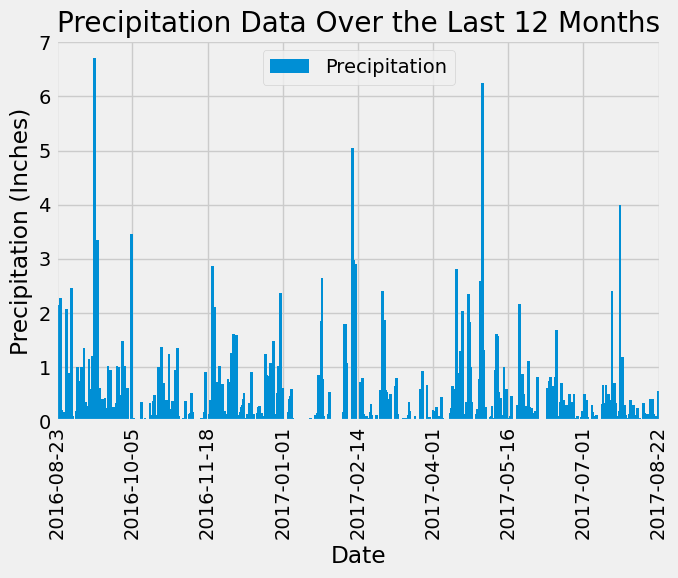

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(days=365)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')  # Convert to string

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date >= one_year_ago_str)\
                    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
# Plot the data using Pandas Plotting with Matplotlib
fig, ax = plt.subplots(figsize=(7,6))
precipitation_df.plot(x='Date', y='Precipitation', kind='bar', label='Precipitation', width=10, ax=ax)
plt.title('Precipitation Data Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
# Set x-axis ticks to display limited number of dates
tick_positions = range(0, len(precipitation_df['Date']), len(precipitation_df['Date']) // 8)
tick_labels = [precipitation_df['Date'].iloc[i] for i in tick_positions]

plt.xticks(tick_positions, tick_labels, rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id)\
    .all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

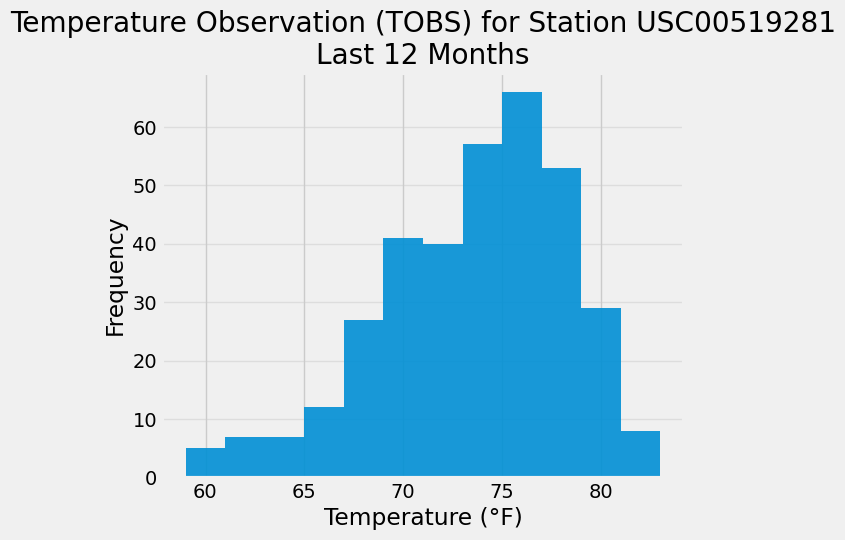

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago_str)\
    .order_by(Measurement.date)\
    .all()
# Convert the query results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(6,5))
plt.hist(tobs_df['Temperature'], bins=12, alpha=0.9)
plt.title(f'Temperature Observation (TOBS) for Station {most_active_station_id}\nLast 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()